In [58]:
import pandas as pd
import numpy as np
# import string as s
import seaborn as sns
# import sz_toolbox as sz
# import math
# import tables
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
# from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
# from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (8, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
# import mpl_toolkits.mplot3d.axes3d as p3
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.datasets.samples_generator import make_swiss_roll
# matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [59]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/'
colormap_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
mark = 'H3K4me3'
# mark = 'H3K27ac'
feather_file = f'{wkdir}{mark}_promoter/fold_change_matrix.feather'
covariate_file = f'{wkdir}clinic_covariate_20181009.csv.added'
chiplib_file = f'{wkdir}57_chipseq_samples_library_ids.csv'
overlap = 0.0
# dist = 'correlation'
# link = 'ward'
dist = 'jaccard' # this is jaccard distance 1-jaccard value
link = 'complete'    
png_file = f'{wkdir}/{mark}_{dist}_{link}_{overlap}_heatmap.png'
# need to add logic, if using jaccard distance, transform fold change to 0 and 1


# 3. color map

In [60]:
df_clrs = pd.read_csv(colormap_file, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]
color_dict['HPV16']

,0,1
0,Negative,#000000
1,Positive,#F15B27


('Negative', '#000000')

'#3953A4'

# 5. hierarchical clustering and plot starts here

In [61]:
def get_legend_categories(df_covariates):
    a = []
    covariate_dict = {}
    for ix, row in pd.DataFrame(df_covariates.apply(lambda x: sorted(x.unique().tolist()), axis=1)).iterrows():
    #     print(ix, row[0])
        item = row[0]
        if item not in a:
            a.append(item)
            covariate_dict[ix] = item
    return covariate_dict

In [62]:
def add_numeric_covariate(df_covariates):
    df_covariates = df_covariates[col_den_labels].fillna(0.0)
    nrows = df_covariates.shape[0]
    fig = plt.figure(figsize=(32,.5*nrows), facecolor='white')
    gs = gridspec.GridSpec(nrows, 2,                            
                           width_ratios=[1,18], 
                           height_ratios=[1]*nrows,
                           wspace=0.0, # horizontal space
                           hspace=0.0  # vertical space
                          )
    grid_num = 0
    for ix, row in df_covariates.iterrows():
        dfa = pd.DataFrame(index=[ix], columns=df_covariates.columns)
        dfa.loc[ix,:] = df_covariates.loc[ix,].astype(float)
        dfa = dfa.astype(float)
        # add cbar ax
        gs0 = gs[grid_num]
        ax0 =  plt.subplot(gs0, frameon=False)   
        _ = ax0.get_xaxis().set_ticks([])
        _ = ax0.get_yaxis().set_ticks([])
        _ = ax0.set_title('')


        # add covariate track legend
        gs1 = gs[grid_num+1]
        _ = ax1 = plt.subplot(gs1, facecolor='white')
        _ = ax1.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax1, 
                        cmap = sns.light_palette('red', as_cmap=True),
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=True,
                        cbar_ax=ax0)
        _ = ax1.tick_params(axis='y', which='major', labelsize=5)
        _ = ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
        _ = ax1.yaxis.tick_right()

        grid_num+=2
    plt.show()
    return dfa


In [63]:
def order_df(df, row_labels, col_labels):
    df = df[col_labels].reindex(row_labels)
    return df

In [64]:
def get_category_cmap(color_dict, categories):
    """
    figure out color for categorical variables based on color dict
    """
    map_dict = {k:v for v, k in  enumerate(categories)} 
    breakpoint()
    clrs = [color_dict[k] for k in categories]
    cmap = colors.ListedColormap(clrs)
    return (map_dict, cmap)

In [65]:
def plot_categorical_covariate(df, gs): 
    # df ordered by row and cols, col order matches dendrogram
    nrows = df.shape[0]
    gssubs = gridspec.GridSpecFromSubplotSpec(nrows, 1,  
                                    height_ratios=[1]*nrows,
                                    subplot_spec=gs)
    grid_num = 0
    for ix, row in df.iterrows():
        categories = sorted(row.unique())
       
        map_dict, cmap = get_category_cmap(color_dict, categories)
        df_mapped = pd.DataFrame(index=[ix], columns=df.columns)
        df_mapped.loc[ix,:] = df.loc[ix,].map(map_dict)#.astype(float)

        # add covariate track legend
        gs11 = gssubs[grid_num]
        ax11 = plt.subplot(gs11, facecolor='white')
        _ = ax11.set_title("")  
        _ = sns.heatmap(df_mapped, 
                        ax=ax11, 
                        cmap=cmap,
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False)#,
#                         cbar_ax=ax00)
        _ = ax11.tick_params(axis='y', which='major', labelsize=5)
        _ = ax11.set_yticklabels(ax11.yaxis.get_majorticklabels(), rotation=0)
        _ = ax11.yaxis.tick_right()
        _ = ax11.set_title("")
        _ = ax11.set_xlabel('')
        _ = ax11.set_ylabel(ix, rotation=0, fontsize=10)
        ax11.get_yaxis().set_label_coords(-0.15,0.5)
#         ax11.yaxis.set_label_position("right")
        grid_num+=1

In [66]:
def plot_categorical_legend(gs, covariate_dict):
    ax =  plt.subplot(gs, frameon=True,facecolor='white')
    num_legends = len(covariate_dict)
    column = 0
    for covariate in covariate_dict:
        groups = covariate_dict[covariate]
        add_patches(covariate, ax, groups, column, color_dict, num_legends)
        column+=1

In [67]:
#use this to make clustered heatmap and use add_covariate to make separate tracksS
def plot_cluster_heatmap(dfm, df_covariates, dist, link):  
    fig = plt.figure(figsize=(16, 20), facecolor='white')
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,15], height_ratios=[10, 2, 3], 
                           wspace=0.0, # horizontal space
                           hspace=0.3)  # vertical space
      
    # plot sample (patient) dendrogram
    ax3 = plt.subplot(gs[3], facecolor='white')
    ax3.set_title("")
    col_den_labels = plot_dengrogram(dfm, ax3, dist, link)
    
    
    # plot categorical covariate heatmap
    plot_categorical_covariate(df_covariates, gs[1])


    # plot categorical lenged
    plot_categorical_legend(gs[5], covariate_dict)
    
#     assert row_den_labels == df_hm.index.tolist()
#     assert col_den_labels == df_hm.columns.tolist()

    
    %time plt.savefig(png_file, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return col_den_labels

In [68]:
def add_patches(covariate, ax, features, column, color_dict, num_legends):
    k = 0
    _ = ax.text(0.0+column*(1/(num_legends + .2)), .9, 
                 covariate, 
                 ha='left', 
                 va='center', 
                 fontsize=12)
#     print(sorted(features))
    for feature in sorted(features):
#         print(feature)
        types = len(features)
        clr = color_dict[feature]
#         clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*(1/(num_legends + .2)), .8-k*0.15), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*(1/(num_legends + .2)), .8-k*0.15+.03, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')

In [69]:
def plot_dengrogram(df, ax, dist, link):
    """
    df: rows are features, intervals marked or not, columns are samples, eg. patient
    add column dendrogram
    pdist(Y,'jaccard') returns jaccard distance, which is 1-jaccard similarity value, pairwise distance, so order in each vector matters, 
    but paired u[i], v[i] change order does not matter. important to note, it ignores pairs with both values are 0.
    pdist([[1, 2, 2], [2,2,1]],'jaccard') = 0.666 not 0
    pdist([0,1,1], [0,0,1]) = 0.5
    """
    matrix = df.T.values
    Z = linkage(pdist(matrix, dist), link)
    col_den = dendrogram(Z, leaf_rotation=90.,
                         labels = df.columns,
                         leaf_font_size=12,
                         show_contracted=True, 
                         ax=ax)
#                          no_labels=True)
    col_den_labels = col_den['ivl']
    return col_den_labels

In [70]:
dfmg = pd.read_feather(feather_file)
dfmg.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
dfmg.fillna(0, inplace=True) # 0 means no signal change relative to controls
# dfmg['std'] = dfmg.apply(lambda x: np.std(x), axis=1)
# dfmg = dfmg[dfmg['std']>dfmg['std'].describe()['75%']].drop('std', axis=1)
dfmg.head()
dfmg.shape

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                 4.73582            5.10685   
        892689        896688                 7.80314            9.67613   
        893968        897967                 7.80314            9.67613   

                                   HTMCP-03-06-02006  HTMCP-03-06-02012  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                 8.52459            9.51227   
        892689        896688                16.17969           20.46108   
        893968        897967                16.17969           20.46108   

                                   HTMCP-03-06-02020  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            2.90228   
        365641        369640                 0.00000            0.00000   
        858261        862260                12.24350           11.25621   
        892689        896688                19.08545           18.89524   
        893968        897967                19.08545           18.89524   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            7.42527   
        365641        369640                 0.00000            3.10827   
        858261        862260                 7.53719           10.10188   
        892689        896688                13.88429           16.31843   
        893968        897967                13.88429           16.31843   

                                   HTMCP-03-06-02042  HTMCP-03-06-02046  ...  \
chr_pro chr_pro_start chr_pro_end                                        ...   
1       34081         38080                  0.00000            0.00000  ...   
        365641        369640                 0.00000            0.00000  ...   
        858261        862260                 8.26992           10.42282  ...   
        892689        896688                16.18029           20.84564  ...   
        893968        897967                16.18029           20.84564  ...   

                                   HTMCP-03-06-02230  HTMCP-03-06-02235  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  3.64580            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                11.10221           16.66255   
        892689        896688                18.98120           25.82695   
        893968        897967                18.98120           25.82695   

                                   HTMCP-03-06-02260  HTMCP-03-06-02261  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        365641        369640                 0.00000            0.00000   
        858261        862260                10.36509           11.24310   
        892689        896688                22.21091           15.50773   
        893968        897967                22.21091           15.50773   

                                   HTMCP-03-06-02266  HTMCP-03-06-02267  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  4.45901            0.00000   
        365641        369640                 0.00000            0.00000   
        858261    

(18015, 51)

In [71]:
if (dist == 'jaccard' ) and (link == 'complete'):
    dfmg = dfmg > 0
    dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        365641        369640                   False              False   

                                   HTMCP-03-06-02006  HTMCP-03-06-02012  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        365641        369640                   False              False   

                                   HTMCP-03-06-02020  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        365641        369640                   False              False   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True               True   
        365641        369640                   False               True   

                                   HTMCP-03-06-02042  HTMCP-03-06-02046  ...  \
chr_pro chr_pro_start chr_pro_end                                        ...   
1       34081         38080                    False              False  ...   
        365641        369640                   False              False  ...   

                                   HTMCP-03-06-02230  HTMCP-03-06-02235  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True              False   
        365641        369640                   False              False   

                                   HTMCP-03-06-02260  HTMCP-03-06-02261  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        365641        369640                   False              False   

                                   HTMCP-03-06-02266  HTMCP-03-06-02267  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True              False   
        365641        369640                   False              False   

                                   HTMCP-03-06-02268  HTMCP-03-06-02320  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        365641        369640                   False              False   

                                   HTMCP-03-06-02330  HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                                        
1       34081         38080                     True               True  
        365641        369640                   False              False  

[2 rows x 51 columns]

In [73]:

df_covariates = pd.read_csv(covariate_file, index_col='patient', sep='\t')
# df_covariates.strelka_mutations = df_covariates.strelka_mutations.astype('int64')
df_covariates = df_covariates.T.fillna('unknown')
df_covariates.head(2)

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02037,HTMCP-03-06-02040,...,HTMCP-03-06-02235,HTMCP-03-06-02256,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
epi_mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Mutated,Mutated,Wild Type,Mutated,Wild Type,Mutated,Mutated,Mutated,Mutated
Remodeller,Wild Type,Wild Type,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Wild Type,Mutated,Wild Type,Mutated,Wild Type,Wild Type,Wild Type,Wild Type,Mutated


In [74]:
def order_covariates(df_covariates, dfmg):
    df_covariates = df_covariates.drop(['Testis-specific chromatin protein', 'REST corepressor',
           'ISWI chromatin remdelling','RNF20/40 complex','strelka_mutations', 'HPV_status'])

    dftmp = df_covariates.drop(['HIV_status', 'clinic_histology', 'tumor_grade', \
                                'age_at_diagnosis', 'epi_mutated']).apply(lambda x: x.map({'Mutated':True, 'Wild Type':False}))
    dftmp = dftmp.T
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    feature_labels = plot_dengrogram(dftmp, ax1, dist, link)
    df_covariates  = df_covariates.reindex(['HIV_status', 'clinic_histology', 'tumor_grade', 'epi_mutated']\
                                           + feature_labels)
    
    feature_labels = df_covariates.index.tolist()
    sample_labels = plot_dengrogram(dfmg, ax2, dist, link)
    
    df_covariates = order_df(df_covariates, feature_labels, sample_labels)
    return df_covariates

    

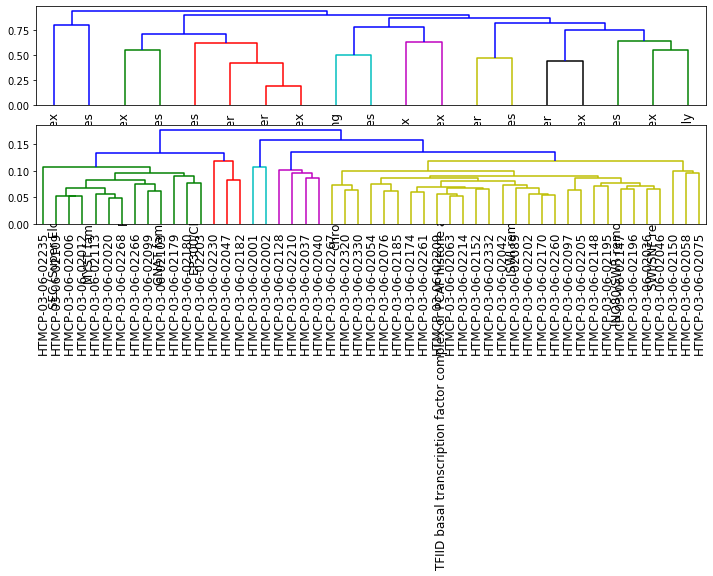

In [75]:
df_covariates = order_covariates(df_covariates, dfmg)

In [76]:
covariate_dict = get_legend_categories(df_covariates)

In [77]:
covariate_dict

{'HIV_status': ['Negative', 'Positive'],
 'clinic_histology': ['Adeno', 'Adenosquamous', 'Neuroendocrine', 'Squamous'],
 'tumor_grade': ['G1', 'G2', 'G3', 'unknown'],
 'epi_mutated': ['Mutated', 'Wild Type']}

> <ipython-input-64-01d29e04cc1d>(7)get_category_cmap()
-> clrs = [color_dict[k] for k in categories]
(Pdb) categories
['Negative', 'Positive']
(Pdb) next
> <ipython-input-64-01d29e04cc1d>(8)get_category_cmap()
-> cmap = colors.ListedColormap(clrs)
(Pdb) next
> <ipython-input-64-01d29e04cc1d>(9)get_category_cmap()
-> return (map_dict, cmap)
(Pdb) next
--Return--
> <ipython-input-64-01d29e04cc1d>(9)get_category_cmap()->({'Negative': 0, 'Positive': 1}, <matplotlib.c...x7f8f1d8bb0f0>)
-> return (map_dict, cmap)
(Pdb) next
> <ipython-input-65-88d792b3e4ea>(12)plot_categorical_covariate()
-> df_mapped = pd.DataFrame(index=[ix], columns=df.columns)
(Pdb) next
> <ipython-input-65-88d792b3e4ea>(13)plot_categorical_covariate()
-> df_mapped.loc[ix,:] = df.loc[ix,].map(map_dict)#.astype(float)
(Pdb) next
> <ipython-input-65-88d792b3e4ea>(16)plot_categorical_covariate()
-> gs11 = gssubs[grid_num]
(Pdb) next
> <ipython-input-65-88d792b3e4ea>(17)plot_categorical_covariate()
-> ax11 = plt.subplot(gs1

KeyError: 'Adeno'

> /projects/da_workspace/software/miniconda/envs/da/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3345)run_code()
-> return outflag
(Pdb) n
Internal StopIteration: True
> /projects/da_workspace/software/miniconda/envs/da/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3248)run_ast_nodes()
-> if (await self.run_code(code, result,  async_=asy)):
--KeyboardInterrupt--
(Pdb) next
> /projects/da_workspace/software/miniconda/envs/da/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249)run_ast_nodes()
-> return True
(Pdb) quit


BdbQuit: 

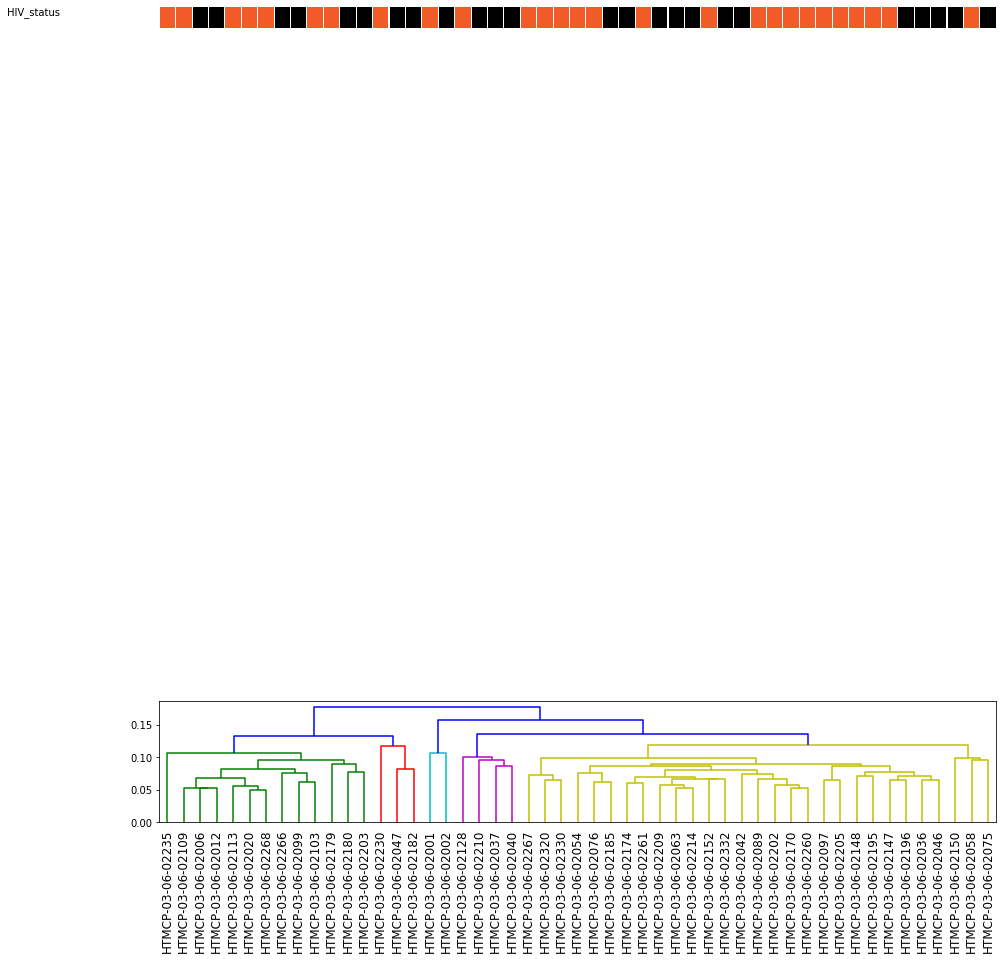

In [78]:
plot_cluster_heatmap(dfmg, df_covariates, dist, link)